# **Character Generation Using Recurrent Neural Networks**

Let's see how a Recurrent Neural Network (RNN) can be trained to generate startup names in Pytorch.

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import os

import numpy as np

import torch
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

## Startup Names
Below is a list of 60 startups in Toronto. These are going to be used as training examples for the RNN in order to generate startup names once trained.

In [0]:
startup_names = ["Well.ca", "500px", "Upverter", "Universe", "InteraXon", "Wave", 
                 "Shopcaster", "Clipstar", "ExpertFile", "Bitstrips", "Kira Talent", 
                 "Joist", "Guardly", "Opencare", "Tulip Retail", "Figure 1", 
                 "Rubikloud", "Canopy Labs", "Validere", "Cadre", "OneClass", 
                 "Clearfit", "Hub", "Shiny Ads", "Synbiota", "close.com", "Bionym", 
                 "Crowdmark", "Pressly", "Webware.io", "Taplytics", "Coherent Path", 
                 "Fan.si", "Street Contxt", "SimplyInsight", "Mosaic Manufacturing", 
                 "Pitstop", "Shoelace", "Gravitational", "Robin", "Rayku", "Careerify", 
                 "Uberflip", "Triggerfox", "Shifthub", "Statflo", "EGT Media", "Neuranet", 
                 "Vantage Analytics", "ECHOage", "PostBeyond", "Kiwi", "Parkbench.com", 
                 "Vantage", "Optimity", "Wealthsimple", "FlashStock Technology Inc.",
                 "ChartMogul", "MindBridge Ai", "Ada Support"]

Preprocess the text by converting upper case letters to lower case

In [0]:
clean_names = [name.lower() for name in startup_names]  

Create mappings for every character

In [0]:
chars = {}
longest_name = 0
for name in clean_names:
    if len(name) > longest_name:
        longest_name = len(name)
    for char in name:
        if char not in chars:
            chars[char] = len(chars)
chars["-"] = len(chars)

In [6]:
chars

{' ': 22,
 '-': 29,
 '.': 3,
 '0': 7,
 '1': 27,
 '5': 6,
 'a': 5,
 'b': 20,
 'c': 4,
 'd': 25,
 'e': 1,
 'f': 19,
 'g': 24,
 'h': 18,
 'i': 15,
 'j': 23,
 'k': 21,
 'l': 2,
 'm': 28,
 'n': 14,
 'o': 17,
 'p': 8,
 'r': 12,
 's': 16,
 't': 13,
 'u': 10,
 'v': 11,
 'w': 0,
 'x': 9,
 'y': 26}

To feed this data to the model, we will have to create a `Dataset` class.

In [0]:
def convert_name(name, chars, max_len, null_char):
    indices = [chars[char] for char in name]
    indices += [chars[null_char] for i in range(max_len - len(indices))]
    return np.array(indices)
  

class PrepareNames(Dataset):
    def __init__(self, names, chars, max_len, null_char):
        self.names = names
        self.chars = chars
        self.max_len = max_len
        self.null_char = null_char
        
    def __len__(self):
        return len(self.names)
      
    def __getitem__(self, idx):
        name = self.names[idx]
        return (convert_name(self.null_char + name[:-1], self.chars, self.max_len, 
                             self.null_char), 
                convert_name(name, self.chars, self.max_len, self.null_char))
          

In [0]:
names_dataset = PrepareNames(clean_names, chars, longest_name, "-")

Now its time to plug the `Dataset` object into a `DataLoader` class

In [0]:
batch_size = 60
train_set = DataLoader(names_dataset, batch_size=batch_size, shuffle=True)

Define an `RNN` model

In [0]:
class RNN(nn.Module):
    def __init__(self, chars_len=30, embedding_dim=10, num_hidden=10, num_steps=26):
        super().__init__()
        self.embed = nn.Embedding(chars_len, embedding_dim)
        self.rnn = nn.RNNCell(embedding_dim, num_hidden, nonlinearity='relu')
        self.linear = nn.Linear(num_hidden, chars_len)
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.num_steps = num_steps
        self.num_hidden = num_hidden
        
    def forward(self, x):
        x_transposed = x.transpose(1, 0)
        h = torch.zeros(x.size(0), self.num_hidden)
        outputs = []
        for i in range(self.num_steps):
            if self.training or i == len(x_transposed) - 1:
                embedding = self.embed(x_transposed[i])
                h = self.rnn(embedding, h)
                out = self.logsoftmax(self.linear(h))
            elif i < len(x_transposed) - 1:
                embedding = self.embed(x_transposed[i])
                h = self.rnn(embedding, h)
                out = torch.zeros_like(self.linear(h))
                out[:, x_transposed[i+1]] = 1
            else:
                sampled_int = np.random.choice(len(outputs[i-1][0]), 1, 
                                               p=torch.exp(outputs[i-1]).data.numpy()[0])
                embedding = self.embed(torch.LongTensor(sampled_int))
                h = self.rnn(embedding, h)
                out = self.logsoftmax(self.linear(h))
            outputs.append(out)
        return torch.stack(outputs).transpose(0, 1)

To train RNNs, the loss across time steps will have to be taken into account.
This is where `SequenceLoss` steps in.

In [0]:
class SequenceLoss(nn.Module):
    def __init__(self, null_char_idx):
        super().__init__()
        self.loss_function = nn.NLLLoss(ignore_index=null_char_idx)

    def forward(self, preds, targets):
        loss = 0
        for i in range(len(preds)):
            loss += self.loss_function(preds[i], targets[i])
        return loss


def train_model(model, train_set, optimizer, null_char_idx):
    model.train()
    epoch_accuracy, epoch_loss = 0, 0
    train_set_size = 0
    for names, labels in train_set:
        batch_size = names.size(0)
        names_var, labels_var = Variable(names), Variable(labels)

        log_probs = model(names_var)
        _, preds = torch.max(log_probs, dim=-1)

        loss = SequenceLoss(null_char_idx)(log_probs, labels_var)
        epoch_loss += loss.data.numpy() * batch_size

        accuracy = preds.eq(labels_var).float().mean().data.numpy() * 100.0
        epoch_accuracy += accuracy * batch_size
        train_set_size += batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_accuracy = epoch_accuracy / train_set_size
    epoch_loss = epoch_loss / train_set_size
    return model, epoch_accuracy, epoch_loss

In [0]:
def run_model(model, train_set, num_epochs, null_char_idx):
    optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())
    train_accuracies, train_losses = [], []
    for epoch in range(num_epochs):
        model, train_accuracy, train_loss = train_model(model, train_set, optimizer, 
                                                        null_char_idx)
        print("epoch {}: train_loss= {:.3}, train_accuracy= {:.4}, ".format(
              epoch, train_loss, train_accuracy))
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
    return model, train_accuracies, train_losses

Run the RNN model

In [13]:
rnn_model, train_accuracies, train_losses = run_model(RNN(num_hidden=200), 
                                                      train_set, 200, -100)

epoch 0: train_loss= 2.03e+02, train_accuracy= 1.795, 
epoch 1: train_loss= 95.9, train_accuracy= 64.87, 
epoch 2: train_loss= 8.04e+04, train_accuracy= 64.87, 
epoch 3: train_loss= 75.0, train_accuracy= 64.87, 
epoch 4: train_loss= 1.51e+02, train_accuracy= 65.9, 
epoch 5: train_loss= 1.77e+02, train_accuracy= 66.73, 
epoch 6: train_loss= 1.87e+02, train_accuracy= 67.63, 
epoch 7: train_loss= 1.91e+02, train_accuracy= 68.78, 
epoch 8: train_loss= 1.93e+02, train_accuracy= 68.01, 
epoch 9: train_loss= 1.93e+02, train_accuracy= 62.95, 
epoch 10: train_loss= 5.44e+02, train_accuracy= 33.72, 
epoch 11: train_loss= 1.93e+02, train_accuracy= 60.96, 
epoch 12: train_loss= 1.92e+02, train_accuracy= 65.13, 
epoch 13: train_loss= 1.92e+02, train_accuracy= 66.92, 
epoch 14: train_loss= 1.92e+02, train_accuracy= 67.95, 
epoch 15: train_loss= 1.91e+02, train_accuracy= 68.46, 
epoch 16: train_loss= 1.9e+02, train_accuracy= 68.65, 
epoch 17: train_loss= 1.88e+02, train_accuracy= 68.65, 
epoch 18: tr

Let's check its loss and accuracy evolution

In [0]:
def plot(train_stats, title, train_label, loc):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.plot(train_stats, label=train_label)
    plt.legend(loc=loc)

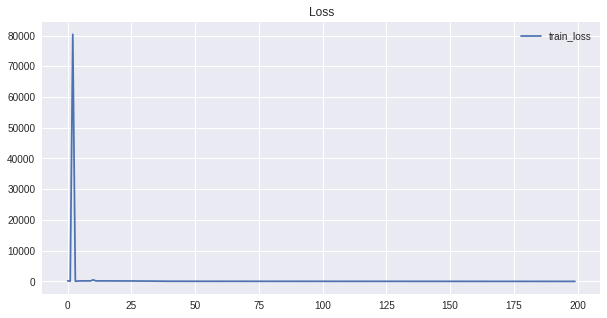

In [15]:
plot(train_losses, "Loss", 'train_loss', 'upper right')

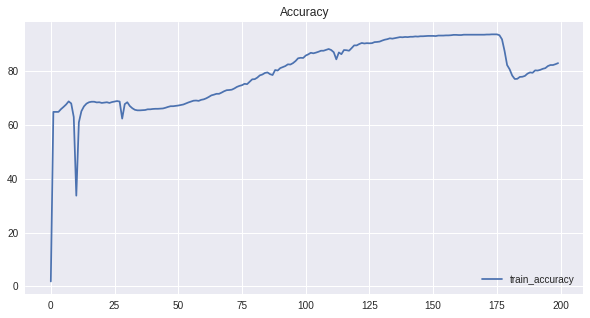

In [16]:
plot(train_accuracies, "Accuracy", 'train_accuracy', 'lower right')

Let's check what startup names this model is able to come up

In [33]:
def convert_generated_name(generated_name, chars):
    max_indices = generated_name.max(-1)[1]
    inv_chars = {val: key for key, val in chars.items()}
    converted_indices = [inv_chars[idx] for idx in max_indices.data.numpy()[0]]
    print("".join(converted_indices).replace("-", ""))
    
rnn_model.eval()
proposed_start = "-tech"
converted_name = convert_name(proposed_start, chars, len(proposed_start), "-")
generated_name = rnn_model(torch.LongTensor(converted_name).view(1, -1))
convert_generated_name(generated_name, chars)

techoalise


Create an alternative LSTM model

In [0]:
class LSTM(nn.Module):
    def __init__(self, chars_len=30, embedding_dim=15, num_hidden=10, num_steps=26):
        super().__init__()
        self.embed = nn.Embedding(chars_len, embedding_dim)
        self.lstm = nn.LSTMCell(embedding_dim, num_hidden)
        self.linear = nn.Linear(num_hidden, chars_len)
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.num_steps = num_steps
        self.num_hidden = num_hidden
        
    def forward(self, x):
        x_transposed = x.transpose(1, 0)
        h, o = torch.zeros(x.size(0), self.num_hidden), torch.zeros(x.size(0), self.num_hidden)
        outputs = []
        for i in range(self.num_steps):
            if self.training or i == len(x_transposed) - 1:          
                embedding = self.embed(x_transposed[i])
                h, o = self.lstm(embedding, (h, o))
                out = self.logsoftmax(self.linear(o))
            elif i < len(x_transposed) - 1:               
                embedding = self.embed(x_transposed[i])
                h, o = self.lstm(embedding, (h, o))
                out = torch.zeros_like(self.linear(o))
                out[:, x_transposed[i+1]] = 1
            else:
                sampled_int = np.random.choice(len(outputs[i-1][0]), 1, 
                                               p=torch.exp(outputs[i-1]).data.numpy()[0])
                embedding = self.embed(torch.LongTensor(sampled_int))
                h, o = self.lstm(embedding, (h, o))
                out = self.logsoftmax(self.linear(o))
            outputs.append(out)
        return torch.stack(outputs).transpose(0, 1)

In [35]:
lstm_model, train_accuracies, train_losses = run_model(LSTM(num_hidden=200), train_set, 
                                                  200, -100)

epoch 0: train_loss= 2.03e+02, train_accuracy= 1.09, 
epoch 1: train_loss= 91.1, train_accuracy= 65.0, 
epoch 2: train_loss= 1.48e+02, train_accuracy= 64.87, 
epoch 3: train_loss= 75.5, train_accuracy= 65.19, 
epoch 4: train_loss= 75.9, train_accuracy= 65.96, 
epoch 5: train_loss= 80.4, train_accuracy= 67.31, 
epoch 6: train_loss= 78.7, train_accuracy= 67.95, 
epoch 7: train_loss= 74.5, train_accuracy= 68.27, 
epoch 8: train_loss= 72.0, train_accuracy= 68.4, 
epoch 9: train_loss= 70.2, train_accuracy= 68.85, 
epoch 10: train_loss= 68.9, train_accuracy= 69.04, 
epoch 11: train_loss= 68.1, train_accuracy= 68.78, 
epoch 12: train_loss= 67.9, train_accuracy= 68.91, 
epoch 13: train_loss= 67.9, train_accuracy= 68.97, 
epoch 14: train_loss= 67.6, train_accuracy= 69.1, 
epoch 15: train_loss= 67.0, train_accuracy= 69.1, 
epoch 16: train_loss= 66.3, train_accuracy= 69.29, 
epoch 17: train_loss= 65.6, train_accuracy= 69.29, 
epoch 18: train_loss= 64.9, train_accuracy= 69.87, 
epoch 19: train_los

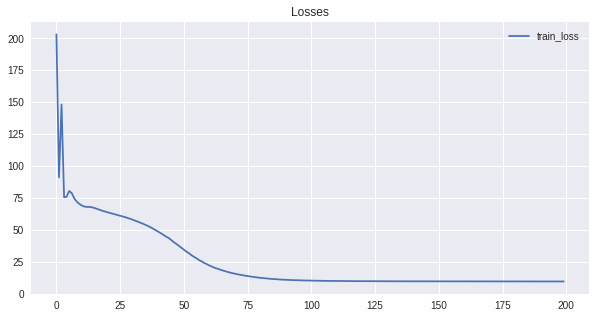

In [36]:
plot(train_losses, "Losses", 'train_loss', 'upper right')

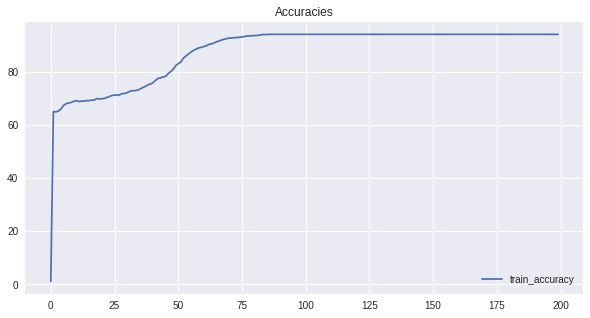

In [37]:
plot(train_accuracies, "Accuracies", 'train_accuracy', 'lower right')

In [43]:
lstm_model.eval()
proposed_start = "-"
converted_name = convert_name(proposed_start, chars, len(proposed_start), "-")
generated_name = lstm_model(torch.LongTensor(converted_name).view(1, -1))
convert_generated_name(generated_name, chars)

citstripstttiiistttittti
